# Adaptation Measures

Adaptation measures are defined by parameters that alter the exposures, hazard or impact functions. Risk transfer options are also considered. Single measures are defined in the `Measure` class, which can be aggregated to a `MeasureSet`.

# Measure class

A measure is characterized by the following attributes:

Related to measure's description:
 * name (str): name of the action
 * haz_type (str): related hazard type (peril), e.g. TC
 * color_rgb (np.array): integer array of size 3. Gives color code of this measure in RGB
 * cost (float): discounted cost (in same units as assets). Needs to be provided by the user. See the example provided in `climada_python/data/system/entity_template.xlsx` sheets `_measures_details` and `_discounting_sheet` to see how the discounting is done.
 
Related to a measure's impact:
 * hazard_set (str): file name of hazard to use
 * hazard_freq_cutoff (float): hazard frequency cutoff
 * exposure_set (str): file name of exposure to use
 * hazard_inten_imp (tuple): parameter a and b of hazard intensity change
 * mdd_impact (tuple): parameter a and b of the impact over the mean damage degree
 * paa_impact (tuple): parameter a and b of the impact over the percentage of affected assets
 * imp_fun_map (str): change of impact function id, e.g. '1to3'
 * exp_region_id (int): region id of the selected exposures to consider ALL the previous parameters
 * risk_transf_attach (float): risk transfer attachment. Applies to the whole exposure.
 * risk_transf_cover (float): risk transfer cover. Applies to the whole exposure.

Paramters description:

`hazard_set` and `exposures_set` provide the file names in h5 format (generated by CLIMADA) of the hazard and exposures to use as a result of the implementation of the measure. These might be further modified when applying the other parameters.

`hazard_inten_imp`, `mdd_impact` and `paa_impact` transform the impact functions linearly as follows: 
 
     intensity = intensity*hazard_inten_imp[0] + hazard_inten_imp[1]
     mdd = mdd*mdd_impact[0] + mdd_impact[1]
     paa = paa*paa_impact[0] + paa_impact[1]
     
`hazard_freq_cutoff` modifies the hazard by putting 0 intensities to the events whose impact exceedance frequency are greater than `hazard_freq_cutoff`.

`imp_fun_map` indicates the ids of the impact function to replace and its replacement. The `if_XX` variable of `Exposures` with the affected impact function id will be correspondingly modified (`XX` refers to the `haz_type` of the measure).

`exp_region_id` will apply all the previous changes only to the `region_id` indicated. This means that only the exposures with that `region_id` and the hazard's centroids close to them will be modified with the previous changes, the other regions will remain unaffected to the measure.

`risk_transf_attach` and `risk_transf_cover` are the deductible and coverage of any event to happen.

Methods description:

The method `check()` validates the attibutes. `apply()` applies the measure to a given exposure, impact function and hazard, returning their modified values. The parameters related to insurability (risk_transf_attach and risk_transf_cover) affect the resulting impact and are therefore not applied in the `apply()` method yet. 

`calc_impact()` calls to `apply()`, applies the insurance parameters and returns the final impact and risk transfer of the measure. This method is called from the `CostBenefit` class.

The method `apply()` allows to visualize the effect of a measure. Here are some examples:

2019-03-29 18:36:14,333 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf


/Users/aznarsig/anaconda3/envs/climada_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0.5,1,'TC: Modified impact function')

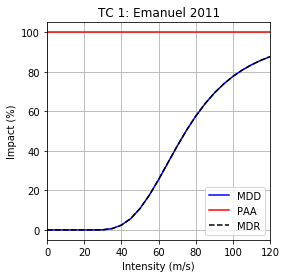

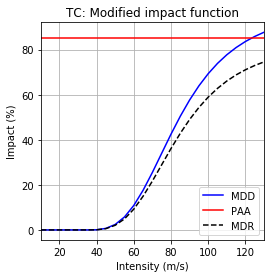

In [1]:
# effect of mdd_impact, paa_impact, hazard_inten_imp
%matplotlib inline
import numpy as np
from climada.entity import Measure, ImpactFuncSet, IFTropCyclone, Exposures
from climada.hazard import Hazard

# define measure
meas = Measure()
meas.name = 'Mangrove'
meas.haz_type = 'TC'
meas.color_rgb = np.array([1, 1, 1])
meas.cost = 500000000
meas.mdd_impact = (1, 0)
meas.paa_impact = (1, -0.15)
meas.hazard_inten_imp = (1, -10) # reduces intensity by 10

# impact functions
if_tc = IFTropCyclone()
if_tc.set_emanuel_usa()
if_all = ImpactFuncSet()
if_all.append(if_tc)
if_all.plot()

# dummy Hazard and Exposures
haz = Hazard('TC') # this measure does not change hazard
exp = Exposures() # this measure does not change exposures

# new impact functions
new_exp, new_ifs, new_haz = meas.apply(exp, if_all, haz)
fig, axes = new_ifs.plot()
axes[0].set_title('TC: Modified impact function')

2019-03-29 18:36:16,488 - climada.entity.exposures.base - INFO - centr_ not set.
2019-03-29 18:36:16,490 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2019-03-29 18:36:16,494 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.
2019-03-29 18:36:20,714 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2019-03-29 18:36:20,716 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.
2019-03-29 18:36:20,732 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2019-03-29 18:36:20,733 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.


(<Figure size 288x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x110c4d5c0>])

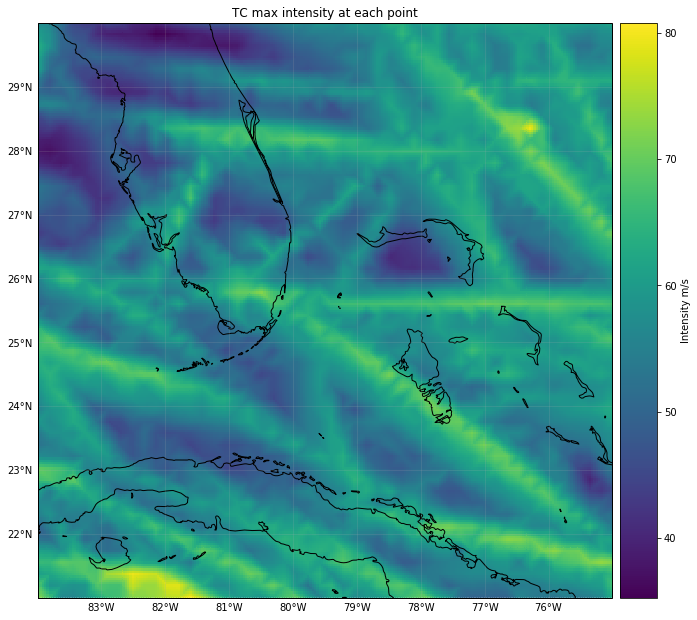

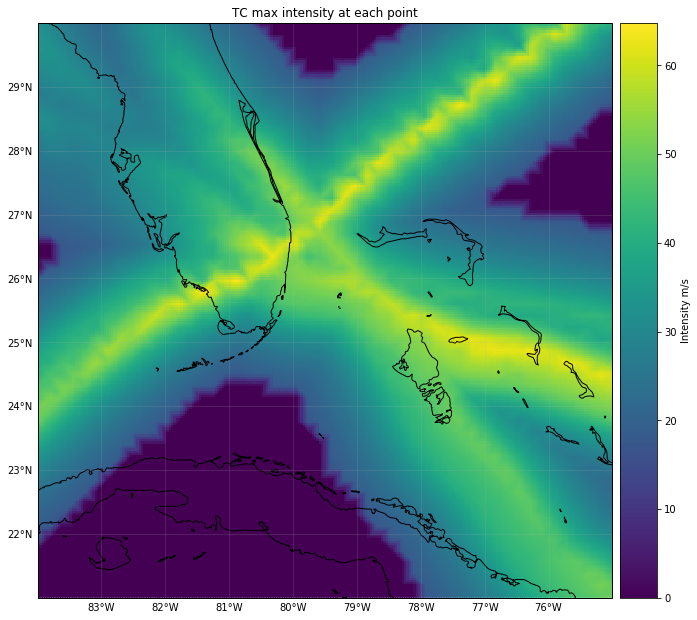

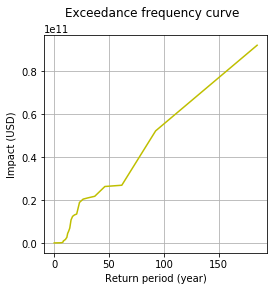

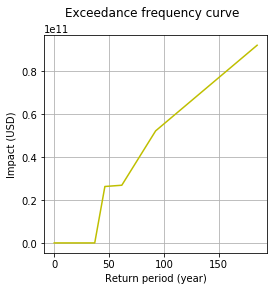

In [2]:
# effect of hazard_freq_cutoff
import numpy as np
from climada.entity import Measure, ImpactFuncSet, IFTropCyclone, Exposures
from climada.hazard import Hazard
from climada.engine import Impact

from climada.util import HAZ_DEMO_H5, EXP_DEMO_H5

# define measure
meas = Measure()
meas.name = 'Mangrove'
meas.haz_type = 'TC'
meas.color_rgb = np.array([1, 1, 1])
meas.cost = 500000000
meas.hazard_freq_cutoff = 0.0255

# impact functions
if_tc = IFTropCyclone()
if_tc.set_emanuel_usa()
if_all = ImpactFuncSet()
if_all.append(if_tc)

# Hazard
haz = Hazard('TC')
haz.read_hdf5(HAZ_DEMO_H5)
haz.check()

# Exposures
exp = Exposures()
exp.read_hdf5(EXP_DEMO_H5)
exp.check()

# new hazard
new_exp, new_ifs, new_haz = meas.apply(exp, if_all, haz)
# if you look at the maximum intensity per centroid: new_haz does not contain the event with smaller impact (the most frequent)
haz.plot_intensity(0)
new_haz.plot_intensity(0)
# you might also compute the exceedance frequency curve of both hazard
imp = Impact()
imp.calc(exp, if_all, haz)
imp.calc_freq_curve().plot()

new_imp = Impact()
new_imp.calc(new_exp, new_ifs, new_haz)
new_imp.calc_freq_curve().plot() # the damages for events with return periods > 1/0.0255 ~ 40 are 0


2019-03-29 18:36:23,350 - climada.entity.exposures.base - INFO - centr_ not set.
2019-03-29 18:36:25,254 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2019-03-29 18:36:25,258 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.
2019-03-29 18:36:25,624 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2019-03-29 18:36:29,743 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2019-03-29 18:36:29,744 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.
2019-03-29 18:36:29,767 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2019-03-29 18:36:29,773 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.


(<Figure size 288x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1a226f3c88>])

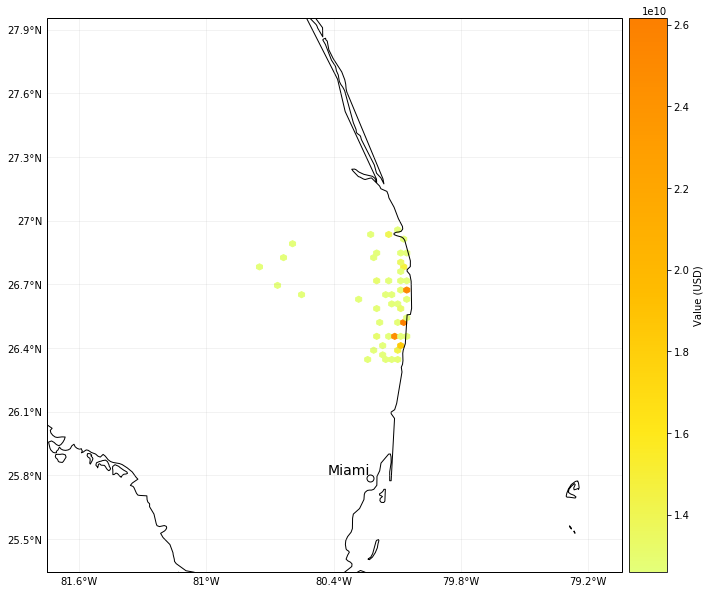

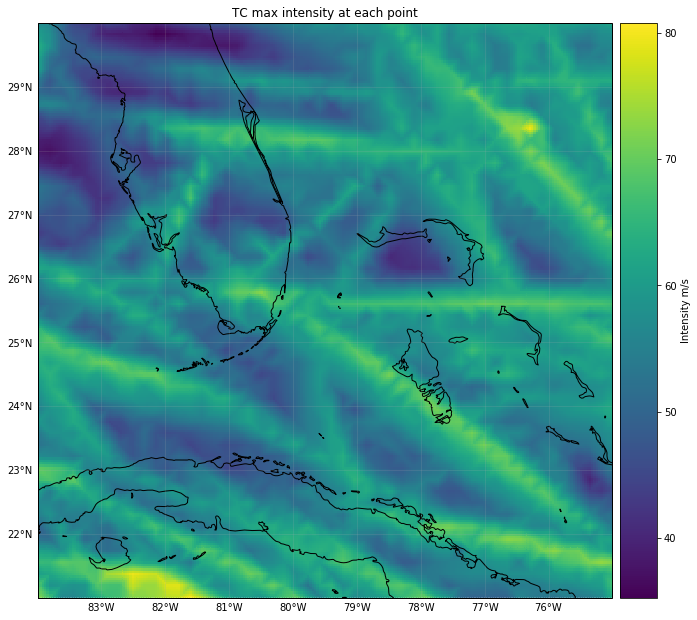

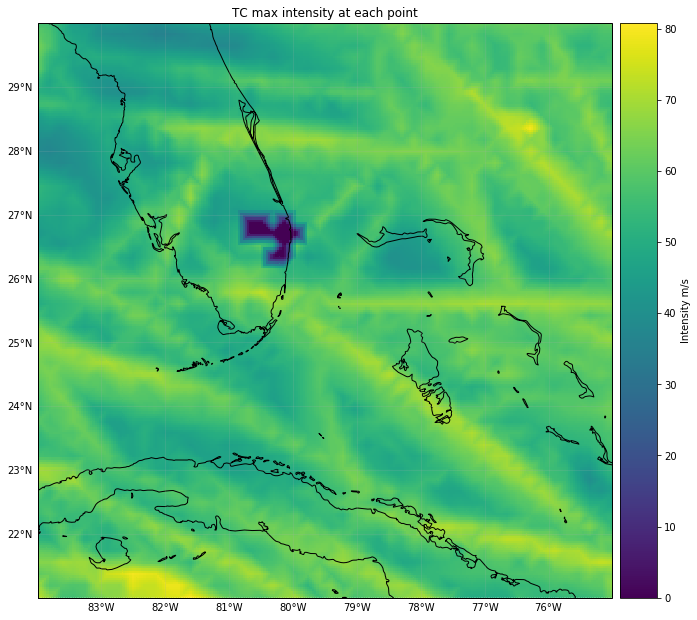

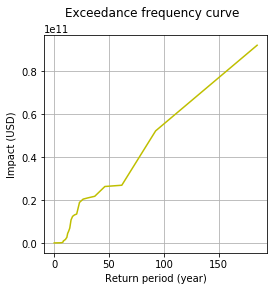

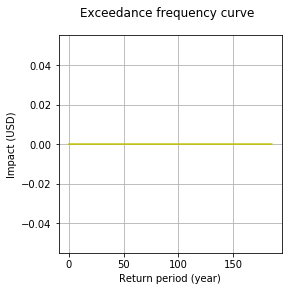

In [3]:
# effect of exp_region_id
import numpy as np
from climada.entity import Measure, ImpactFuncSet, IFTropCyclone, Exposures
from climada.hazard import Hazard
from climada.engine import Impact

from climada.util import HAZ_DEMO_H5, EXP_DEMO_H5

# define measure
meas = Measure()
meas.name = 'Building code'
meas.haz_type = 'TC'
meas.color_rgb = np.array([1, 1, 1])
meas.cost = 500000000
meas.hazard_freq_cutoff = 0.00455
meas.exp_region_id = 1 # apply measure to points close to exposures with region_id=1

# impact functions
if_tc = IFTropCyclone()
if_tc.set_emanuel_usa()
if_all = ImpactFuncSet()
if_all.append(if_tc)

# Hazard
haz = Hazard('TC')
haz.read_hdf5(HAZ_DEMO_H5)
haz.check()

# Exposures
exp = Exposures()
exp.read_hdf5(EXP_DEMO_H5)
#exp['region_id'] = np.ones(exp.shape[0])
exp.check()
# all exposures have region_id=1
exp.plot_hexbin(buffer=1.0)

# new hazard
new_exp, new_ifs, new_haz = meas.apply(exp, if_all, haz)
# the cutoff has been apllied only in the region of the exposures
haz.plot_intensity(0)
new_haz.plot_intensity(0)

# the exceddance frequency has only been computed for the selected exposures before doing the cutoff.
# since we have removed the hazard of the places with exposure, the new exceedance frequency curve is zero.
imp = Impact()
imp.calc(exp, if_all, haz)
imp.calc_freq_curve().plot()

new_imp = Impact()
new_imp.calc(new_exp, new_ifs, new_haz)
new_imp.calc_freq_curve().plot()

2019-03-29 18:36:33,296 - climada.entity.exposures.base - INFO - centr_ not set.
2019-03-29 18:36:33,297 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2019-03-29 18:36:33,303 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.
2019-03-29 18:36:33,323 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2019-03-29 18:36:33,324 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 2405 events.
risk_transfer 1.11e+08


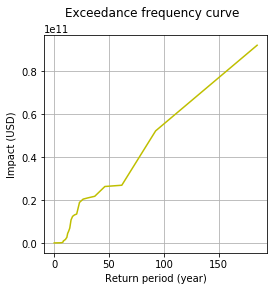

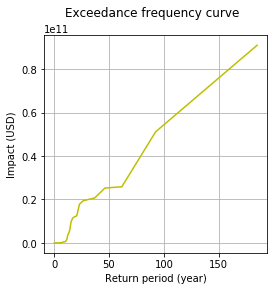

In [4]:
# effect of risk_transf_attach and risk_transf_cover
import numpy as np
from climada.entity import Measure, ImpactFuncSet, IFTropCyclone, Exposures
from climada.hazard import Hazard
from climada.engine import Impact

from climada.util import HAZ_DEMO_H5, EXP_DEMO_H5

# define measure
meas = Measure()
meas.name = 'Insurance'
meas.haz_type = 'TC'
meas.color_rgb = np.array([1, 1, 1])
meas.cost = 500000000
meas.risk_transf_attach = 5.0e8
meas.risk_transf_cover = 1.0e9

# impact functions
if_tc = IFTropCyclone()
if_tc.set_emanuel_usa()
if_all = ImpactFuncSet()
if_all.append(if_tc)

# Hazard
haz = Hazard('TC')
haz.read_hdf5(HAZ_DEMO_H5)
haz.check()

# Exposures
exp = Exposures()
exp.read_hdf5(EXP_DEMO_H5)
exp.check()

# impact before
imp = Impact()
imp.calc(exp, if_all, haz)
imp.calc_freq_curve().plot()

# impact after. risk_transf will be added to the cost of the measure
imp_new, risk_transf = meas.calc_impact(exp, if_all, haz)
imp_new.calc_freq_curve().plot()
print('risk_transfer {:.3}'.format(risk_transf))

# MeasureSet class

Similarly to the `ImpactFuncSet`, `MeasureSet` is a container which handles `Measure` instances through the methods `append()`, `extend()`, `remove_measure()`and `get_measure()`. Use the `check()` method to make sure all the measures have been propoerly set. 

`MeasureSet` contains the attribute `tag` of type `Tag`, which stores information about the data: the original file name and a description.

In [5]:
from climada.entity import MeasureSet
help(MeasureSet)

Help on class MeasureSet in module climada.entity.measures.measure_set:

class MeasureSet(builtins.object)
 |  Contains measures of type Measure. Loads from
 |  files with format defined in FILE_EXT.
 |  
 |  Attributes:
 |      tag (Tag): information about the source data
 |      _data (dict): cotains Measure classes. It's not suppossed to be
 |          directly accessed. Use the class methods instead.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Empty initialization.
 |      
 |      Examples:
 |          Fill MeasureSet with values and check consistency data:
 |      
 |          >>> act_1 = Measure()
 |          >>> act_1.name = 'Seawall'
 |          >>> act_1.color_rgb = np.array([0.1529, 0.2510, 0.5451])
 |          >>> act_1.hazard_intensity = (1, 0)
 |          >>> act_1.mdd_impact = (1, 0)
 |          >>> act_1.paa_impact = (1, 0)
 |          >>> meas = MeasureSet()
 |          >>> meas.append(act_1)
 |          >>> meas.tag.description = "my dummy MeasureSe

In [6]:
# build measures
import numpy as np
import matplotlib.pyplot as plt
from climada.entity import Measure, MeasureSet

meas_1 = Measure()
meas_1.haz_type = 'TC'
meas_1.name = 'Mangrove'
meas_1.color_rgb = np.array([1, 1, 1])
meas_1.cost = 500000000
meas_1.mdd_impact = (1, 2)
meas_1.paa_impact = (1, 2)
meas_1.hazard_inten_imp = (1, 2)
meas_1.risk_transf_cover = 500

meas_2 = Measure()
meas_2.haz_type = 'TC'
meas_2.name = 'Sandbags'
meas_2.color_rgb = np.array([1, 1, 1])
meas_2.cost = 22000000
meas_2.mdd_impact = (1, 2)
meas_2.paa_impact = (1, 3)
meas_2.hazard_inten_imp = (1, 2)
meas_2.exp_region_id = 2

# gather all measures
meas_set = MeasureSet()
meas_set.append(meas_1)
meas_set.append(meas_2)
meas_set.check()

# select one measure
meas_sel = meas_set.get_measure(name='Sandbags')
print(meas_sel[0].name, meas_sel[0].cost)

Sandbags 22000000


## Read measures of an Excel file

Measures defined in an excel file following the template provided in sheet `measures` of `climada_python/data/system/entity_template.xlsx` can be ingested directly using the method `read_excel()`.

In [7]:
from climada.entity import MeasureSet
from climada.util import ENT_TEMPLATE_XLS

# Fill DataFrame from Excel file
file_name = ENT_TEMPLATE_XLS # provide absolute path of the excel file
meas_set = MeasureSet()
meas_set.read_excel(file_name)
print('Read file:', meas_set.tag.file_name)

Read file: /Users/aznarsig/Documents/Python/climada_python/data/system/entity_template.xlsx


## Write measures

Measures can be writen in Excel format using `write_excel()` method.

In [8]:
from climada.entity import MeasureSet
from climada.util import ENT_TEMPLATE_XLS

# Fill DataFrame from Excel file
file_name = ENT_TEMPLATE_XLS # provide absolute path of the excel file
meas_set = MeasureSet()
meas_set.read_excel(file_name)

# write file
meas_set.write_excel('results/tutorial_meas_set.xlsx')

Pickle can always be used as well:

In [9]:
from climada.util.save import save
# this generates a results folder in the current path and stores the output there
save('tutorial_meas_set.p', meas_set)

2019-03-29 18:36:33,643 - climada.util.save - INFO - Written file /Users/aznarsig/Documents/Python/climada_python/script/tutorial/results/tutorial_meas_set.p
